In [1]:
working_dir = '/mnt/c/users/fordd/Downloads/RW_PGM_FE/'
py_files_dir =  working_dir+'py_files/'
saved_arrays_dir = working_dir+'saved_arrays/'
saved_models_dir = working_dir+'saved_models/'
pdb_files_dir = working_dir+'pdb_files/'
trajectory_files_dir = working_dir+'trajectory_files/'

In [2]:
import os

os.chdir(py_files_dir)

from utils import *
from model import *
from IC_MAP import *

os.chdir(working_dir)

In [3]:
T = 600 # K
PDB = pdb_files_dir+'alanine-dipeptide-in-vacuum.pdb'
inds_CVs = [[4, 6, 8, 14], [6, 8, 14, 16]]
FF_name = "amber99sbildn.xml"

In [4]:
get_labels_ = get_labels_from_CVs_alanine_dipeptide_

In [6]:
smiv = Single_Molecule_In_Vaccum(PDB,
                                 FF = FF_name,
                                 default_temperature = T)

using app.ForceField
# cpu cores will be used for evaluation: 16


In [8]:
path_dataset = trajectory_files_dir+'/AD'+str(T)+'u'

# The current unbiased dataset (not expected to be globally ergodic) is
# a single trajectory.

smiv.load_simulation_data_(path_dataset)

loading ['AD600u_200ns_u', 'AD600u_200ns_xyz']


In [12]:
u_ = Local_PE(
global_potential_energy_function_ = smiv.u_,
clustering_function_ = lambda xyz : get_labels_(get_torsional_CVs_(xyz,inds_CVs)),       
) 
u = smiv.u
##
#xyz = smiv.xyz ; print(xyz.shape)
##
xyz = smiv.xyz*0.1 ; print(xyz.shape)
##
if None in smiv.s: CVs = get_torsional_CVs_(xyz,inds_CVs)
else:              CVs = smiv.s
if None in smiv.v: metaD_weights = np.ones([len(u),1])
else:              metaD_weights = np.exp(smiv.v)

(1000000, 22, 3)


In [16]:
# uniform weights because data unbiased:
(metaD_weights-1).sum()

0.0

In [17]:
labels = get_labels_(CVs)
n_states = len(set(labels))
inds_states = [np.where(labels==k)[0] for k in range(n_states)]
counts_states = [len(x) for x in inds_states]
print('number of metastable states:',n_states)

number of metastable states: 4


In [18]:
# known from notebook 'AD_and_IB_WTmetaD_FE_plots'
delta_f_ground_truth = np.array([0.02390266, 0.31251421, 0.        , 1.74955772])

In [21]:
# running FE estimates from counts:
delta_f_states = deltaf_states_in_time_(labels,weights=metaD_weights,align=True)

FE estimates of state 0 (often the lowest FE) moved to around 0


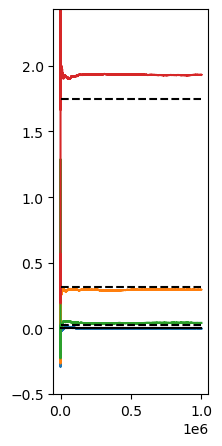

In [24]:
eps = 0.5
fig = plt.figure(figsize=(2,5))

plt.plot(delta_f_states )
plt.plot([0,len(delta_f_states)],[0,0], color='black')
plt.ylim(-eps,delta_f_states[-1].max()+eps)
[plt.plot([0,len(u)],[x]*2,'--',color='black') for x in delta_f_ground_truth]
plt.show()

/tmp/ipykernel_2275/3542413967.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(-np.log(np.flip(np.histogramdd(CVs,bins=60,range=[[-PI,PI]]*2,density=True)[0].T,axis=0)),cmap='jet')


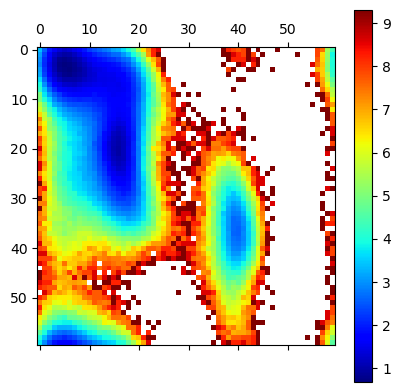

In [26]:
if smiv.FES is None:
    plt.matshow(-np.log(np.flip(np.histogramdd(CVs,bins=60,range=[[-PI,PI]]*2,density=True)[0].T,axis=0)),cmap='jet')
else:
    plt.matshow(np.flip(smiv.FES,axis=0),cmap='jet')
plt.colorbar()

In [27]:
ic_map = XR_MAP_mixed_only(PDB)
xyz = ic_map.align_data_(xyz,
                         eps_singularity = [1e-6,1e-6],
                         )
xyz.shape

full IC would be possible
next run align_data_(R_data)
inds_keep_cartesian: [6 4 8]
These indices work. All atoms can be reached.
# variables static:    6
# variables isotropic: 0
# variables flowing:   60
# total variables 66


(1000000, 22, 3)

cartesian atoms (from which 6 dof are removed) via alignment: [4 6 8]
n_hydrogens 12


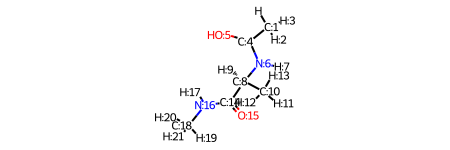

In [28]:
print('cartesian atoms (from which 6 dof are removed) via alignment:',ic_map.inds_XYZ)
print('n_hydrogens',ic_map.n_hydrogens)
ic_map.mol

True


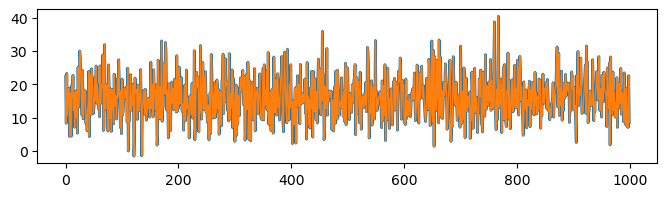

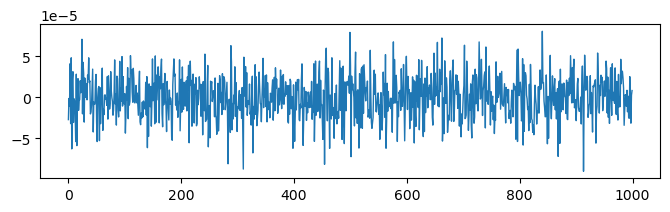

In [29]:
# check that alligned data has the same potential enregies as saved during simulation.
N_total = xyz.shape[0]
rand_inds = np.random.choice(N_total,1000,replace=False)
fig = plt.figure(figsize=(8,2))
plt.plot(u_(xyz[rand_inds]), linewidth=2)
plt.plot(u[rand_inds], linewidth=1)
print(np.allclose(u_(xyz[rand_inds]), u[rand_inds], atol=1e-4))
plt.show()
fig = plt.figure(figsize=(8,2))
plt.plot(u[rand_inds] - u_(xyz[rand_inds]), linewidth=1)
plt.show()

In [30]:
print('counts_states:',counts_states)
training_set_size = min(counts_states)//2
print('size of the training and validation sets:', training_set_size)

counts_states: [351447, 261294, 336420, 50839]
size of the training and validation sets: 25419


Want training_set_size number of datapoints from each state to make a training set. Want training_set_size number of other datapoints from each state to make a validation set. Want both training and validation sets to have similar average potential energies as the more reliable averages over all available data (av_u_GT0).

0 : 0.009820758805610383


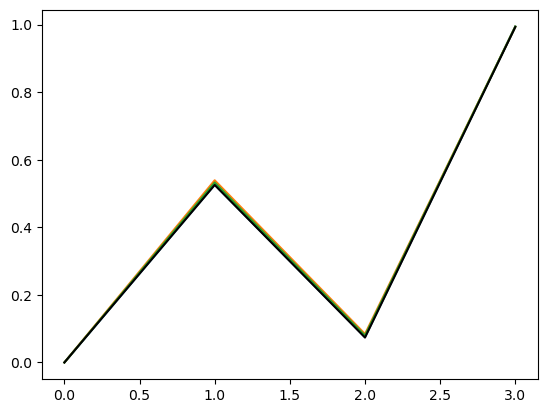

In [31]:
av_u_GT0 = np.array([u[inds_states[k]].mean() for k in range(n_states)])
av_u_GT0 -= av_u_GT0.min()

done = False
for i in range(1000):
    if not done:
        _inds_rand = None
        _inds_rand = load_pickle_(saved_arrays_dir+'_inds_rand_AD600u_II')
        training, validation, _inds_rand = split_into_training_data_(xyz,u,metaD_weights,
                                            labels=labels,
                                            training_set_size=training_set_size,
                                            inds_rand = _inds_rand)
        xyz_training, u_training, w_training = training
        xyz_validation, u_validation, w_validation = validation
        del training, validation 

        w_training = [x/x.sum() for x in w_training]
        w_validation = [x/x.sum() for x in w_validation]

        ##

        av_u_T = np.array([pool_(u_training[k],w_training[k]) for k in range(n_states)])
        av_u_T -= av_u_T.min()
        av_u_V = np.array([pool_(u_validation[k],w_validation[k]) for k in range(n_states)])
        av_u_V -= av_u_V.min()
        av_u_GT = (av_u_V+av_u_T)*0.5
        av_u_GT -= av_u_GT.min()
        ##
        err = (np.linalg.norm(av_u_GT0-av_u_GT) + np.linalg.norm(av_u_GT0-av_u_T) + np.linalg.norm(av_u_GT0-av_u_V) )/3
        if err <= 0.009820758805610383:
            done = True
            print(i,':',err)
        else: done = False

plt.plot(av_u_T)
plt.plot(av_u_V)
plt.plot(av_u_GT)
plt.plot(av_u_GT0 - av_u_GT0.min(),color='black')

In [32]:
print([x.shape for x in xyz_training])
print([x.shape for x in xyz_validation])

print([x.shape for x in u_training])
print([x.shape for x in u_validation])

print([x.shape for x in w_training])
print([x.shape for x in w_validation])

[(25419, 22, 3), (25419, 22, 3), (25419, 22, 3), (25419, 22, 3)]
[(25419, 22, 3), (25419, 22, 3), (25419, 22, 3), (25419, 22, 3)]
[(25419, 1), (25419, 1), (25419, 1), (25419, 1)]
[(25419, 1), (25419, 1), (25419, 1), (25419, 1)]
[(25419, 1), (25419, 1), (25419, 1), (25419, 1)]
[(25419, 1), (25419, 1), (25419, 1), (25419, 1)]


In [33]:
inds_rand = np.random.choice(training_set_size,100,replace=False)

for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-4))
    
k=0
for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-4))
    k+=1

True
True
True
True
True
True
True
True


In [34]:
def plot_check_(xyz_tv, w_tv = None):
    n_states = len(xyz_tv)
    if w_tv is None: w_tv = [None]*n_states
    else: w_tv = [x.flatten() for x in w_tv]
    for k in range(n_states):
        hist = np.histogramdd(get_torsional_CVs_(xyz_tv[k],inds_CVs),
                              bins=60,
                              range = [[-PI,PI]]*2,
                              weights=w_tv[k],
                              density=True,
                             )[0]
        hist /= hist.sum()
        hist = np.where(hist==0.0,np.nan,hist)
        plt.contour(hist.T, cmap='jet', levels=50)#, colors='C'+str(k), levels=5)
    plt.colorbar()

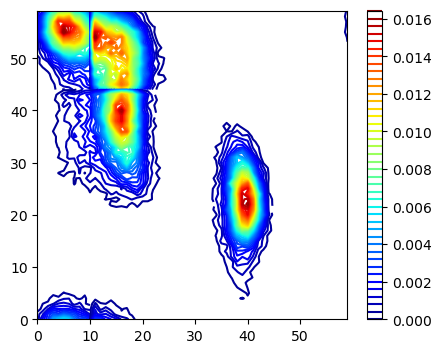

In [35]:
fig = plt.figure(figsize=(5,4))
plot_check_(xyz_training)
plt.show()

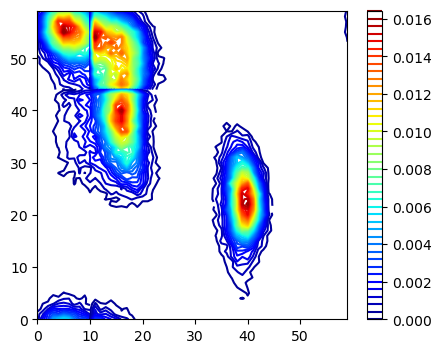

In [36]:
fig = plt.figure(figsize=(5,4))
plot_check_(xyz_training, w_training)
plt.show()

In [37]:
PM = ic_map.CSR_obj.periodic_mask
flow_masks = get_list_cond_masks_unsupervised_(len(PM)) ; print(len(flow_masks))
flow_masks = get_random_flow_masks_(len(PM),4) ; print(len(flow_masks))

6
4


In [42]:
flow_masks = load_pickle_(saved_arrays_dir+'random_flow_masks_AD_(use_in_all_AD)')

In [39]:
learning_rate = 0.001
rate_decay = 0.0001

In [40]:
for k in range(n_states):
    globals()['model_'+str(k)] = MODEL_3(periodic_mask = PM,
                                    list_cond_masks = flow_masks,
                                    IC_map = ic_map,
                                    optimiser_LR_decay = [learning_rate, rate_decay],

                                    n_bins_periodic = 8,
                                    number_of_splines_periodic = 2,
                                    n_bins_other = 8,

                                    n_hidden = 1,
                                    hidden_activation = tf.nn.silu,
                                    min_bin_width = 1e-3,
                                    trainable_slopes = True,
                                    min_knot_slope = 1e-3,
                                    dims_hidden = None,
                                    nk_for_periodic_MLP_encoding = 1,
                                    )

There are 7279998 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 7279998 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 7279998 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 7279998 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 


In [41]:
trainer = TRAINER(models = [globals()['model_'+str(k)] for k in range(n_states)],
        max_training_batches = 50000,
        n_batches_between_evaluations = 50,
       )

FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 0 (often the lowest FE) moved to around 0
FE estimates of state 0 (often the lowest FE) moved to around 0


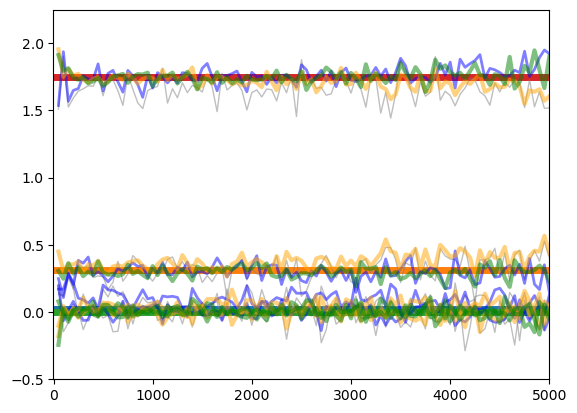

In [29]:
trainer.train(
            n_batches = 5000,
    
            training_batch_size = 1000,
            evalation_batch_size = 10000,
    
            xyz_training = xyz_training,
            u_training = u_training,
            xyz_validation = xyz_validation,
            u_validation = u_validation,
    
            potential_energy_function = u_,
            
            delta_f_ground_truth = delta_f_ground_truth,
            
            evaluate_main = True,
            f_window_grain_BAR_local = [-50,50,2000],
            shuffle = True,
    
            name_save_BAR_inputs = saved_arrays_dir+'AD600u_BAR_inputs_II',
            name_save_mBAR_inputs = saved_arrays_dir+'AD600u_MBAR_inputs_II',
)

In [30]:
#trainer.save_the_above_(saved_arrays_dir+'AD600u_est_grid_AVall_II')

saved AD600u_est_grid_AVall_II


In [31]:
#for k in range(n_states):
#    globals()['model_' + str(k)].save_model(saved_models_dir+'model_'+str(k)+'_AD600u_II')

saved model_0_AD600u_II
saved model_1_AD600u_II
saved model_2_AD600u_II
saved model_3_AD600u_II


In [ ]:
## results plotted in a different notebook 'AD600u_mBAR'

In [32]:
rs = []
negS_BGs = []
for k in range(n_states):
    r_samples, negS_BG = trainer.models[k].sample_model(10000)
    rs.append(r_samples)
    negS_BGs.append(negS_BG)
    
ss = [get_torsional_CVs_(r,inds_CVs=inds_CVs) for r in rs]

In [33]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

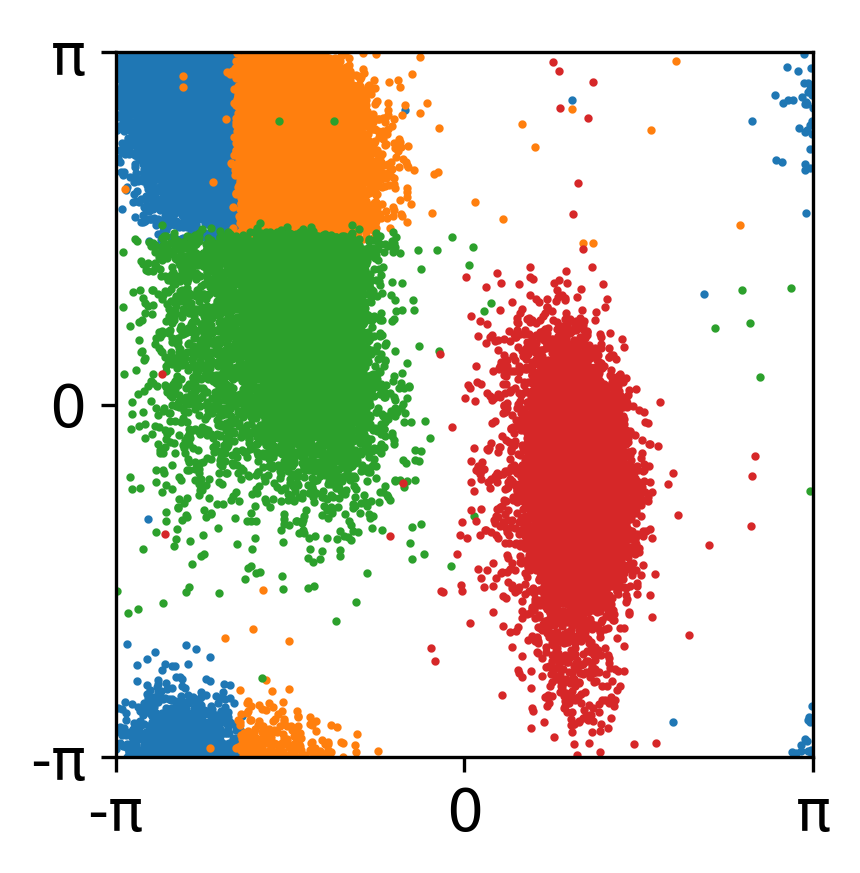

In [34]:
fig = plt.figure(figsize=(3,3.05),dpi=300)
for k in range(n_states):
    plt.scatter(ss[k][:,0],ss[k][:,1],s=1)
    
plt.xlim(-PI,PI)
plt.ylim(-PI,PI)
plt.xticks([-PI,0,PI],['-π','0','π'])
plt.yticks([-PI,0,PI],['-π','0','π'])
plt.show()